In [7]:
%autosave 300
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [8]:
import os

os.chdir("..")
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/Abi_GenAI_Sessions/notebooks


In this notebook we will discuss the internal working of encoder-decoder transformer model for language translation.
* The primary goal of this notebook is to understand the internal working of the transformer model and how the model is able to generate the translation of the input sentence.
* Basic working of attention mechanism in transformer model.
* Model training and Inferencing while generating translation text

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR

In [31]:
class Config:
    N = 6
    d_model = 512
    d_ff = 2048
    h = 8
    dropout_rate = 0.1

Which is what I have in the config:

* N -> number of encoder and decoder blocks
* d_model -> dimension of the embedding model
* h -> number of heads in the multi-head attention
* d_ff -> dimension of the feed forward network
* dropout_rate -> dropout rate

The main components of involved in the transformer architecture are as follows:
* Input Embeddings
* Positional Encodings
* Multi-Head Attention with and without mask
* Layer Normalization
* Feed Forward NN
* Residual Connection

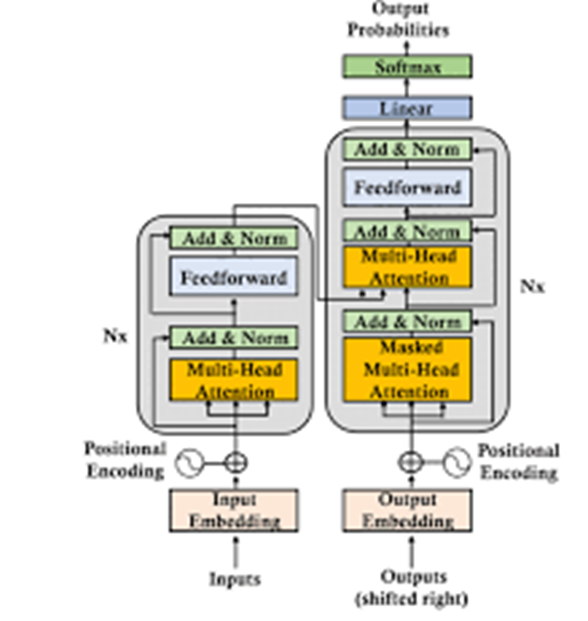

##### __Utils__

In [32]:
def clones(module, N):
    """Produce N identical layers."""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

##### __Encoder Decoder Shell__

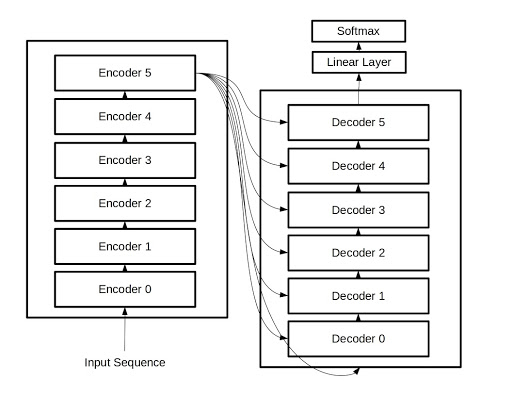

In [33]:
class EncoderDecoder(nn.Module):
    """A standard Encoder-Decoder architecture
    Encoder: Encoder layer
    Decoder: Decoder layer
    src_embed: source embedding layer
    tgt_embed: target embedding layer
    generator: final output layer
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def encoder_step(self, src, src_mask):
        """ Encoder step"""
        encoder_op = self.encoder(self.src_embed(src), src_mask)
        return encoder_op

    def decoder_step(self, memory, src_mask, tgt, tgt_mask):
        """Decoder step"""
        decoder_op = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return decoder_op

    def forward(self, src, tgt, src_mask, tgt_mask):
        """Full Encoder-Decoder forward pass"""
        kv_memory = self.encoder_step(src, src_mask)
        final_op = self.decoder_step(kv_memory, src_mask, tgt, tgt_mask)
        return final_op

##### __Outer Linear + Softmax Layer: Projection Layer__

In [34]:
class ProjectionLayer(nn.Module):
    """Define standard linear + softmax generation step."""

    def __init__(self, d_model, vocab):
        super().__init__()
        self.projection = nn.Linear(d_model, vocab)

    def forward(self, x):
        op = F.log_softmax(self.projection(x))
        return op

##### __LayerNorm__

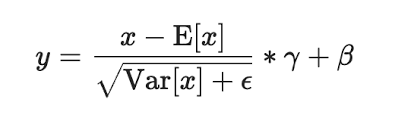

In [35]:
class LayerNorm(nn.Module):
    """Construct a layernorm module"""

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.ones(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        norm = self.alpha * (x - mean) / (std + self.eps) + self.beta
        return norm

##### __ResidualNetwork__

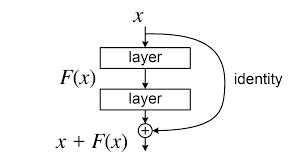

In [36]:
class SubLayerConnection(nn.Module):
    """A residual connection followed by a layer norm"""
    def __init__(self, size, dropout_rate):
        super().__init__()
        self.norm = LayerNorm(features=size)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x, sublayer):
        op = x + self.dropout(sublayer(self.norm(x)))
        return op

##### __Encoder Stacks__ 
The encoder is composed of a stack of N=6 identical layers in this case


First lets focus on the encoder part of the architecture

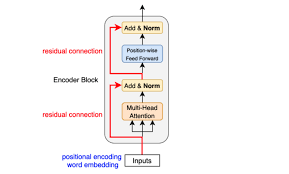

##### __EncoderBlock__

In [37]:
class EncoderBlock(nn.Module):
    """Encoder is made up of self-attn and feed forward (defined below)"""

    def __init__(self, size, self_attn, feed_forward, dropout_rate):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropout_rate), 2)
        self.size = size

    def forward(self, x, mask):
        # self attention layer followed by feed forward layer
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask)) # imp point- input to self_attn is same as query, key and value
        x = self.sublayer[1](x, self.feed_forward)
        return x

In [38]:
class Encoder(nn.Module):
    """Core encoder is a stack of N layers"""

    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        # Pass the input (and mask) through each layer in turn
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

##### __DecoderStacks__

Now lets design the decoder part of the architecture

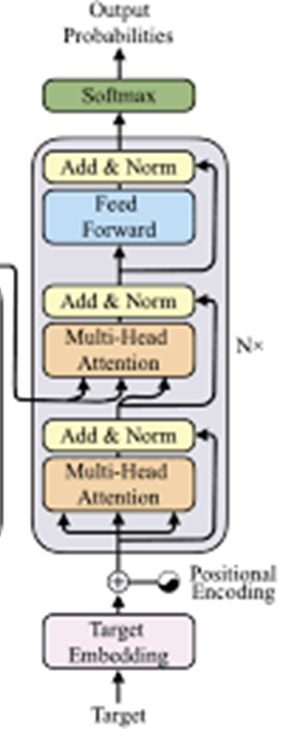

In [54]:
class DecoderBlock(nn.Module):
    """Decoder is made of self-attn, src-attn, and feed forward (defined below)"""

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout_rate):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sub_layer = clones(SubLayerConnection(size, dropout_rate), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # self attention, src attention, feed forward layer
        m = memory
        x = self.sub_layer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) # input to self_attn is same as query, key and value
        x = self.sub_layer[1](x, lambda x: self.src_attn(x, m, m, src_mask)) # query as input to self_attn, key and value from encoder
        x = self.sub_layer[2](x, self.feed_forward)
        return x

In [55]:
class Decoder(nn.Module):
    """Generic N layer decoder with masking."""

    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        # Pass the input (and mask) through each layer in turn
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)

        return self.norm(x)

##### __AttentionMask__

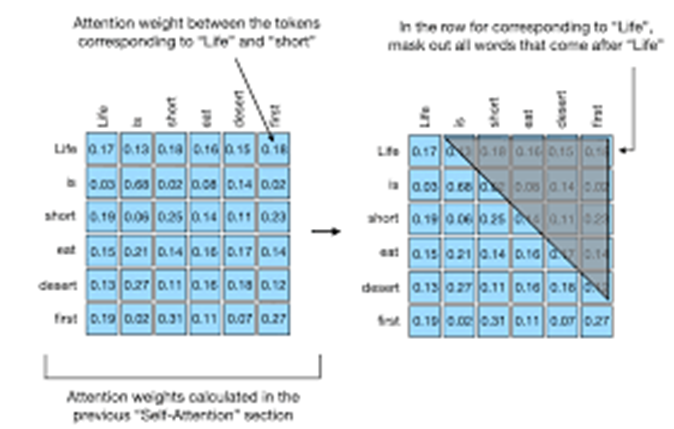

In [41]:
def attention_mask(size):
    """Mask out subsequent positions."""
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(torch.uint8)
    return subsequent_mask == 0

#### __AttentionBlock__

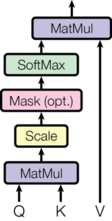

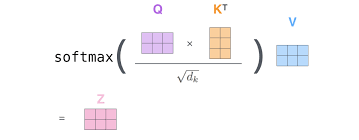

### **Multi-Head Attention Shape Changes and Detailed Explanation**

#### **1. Initial Input**: 
- **Input Tensor**: `X`
- **Shape**: `(batch_size, seq_len, d_model)`
  - `batch_size`: Number of sequences in a batch.
  - `seq_len`: Length of each sequence (number of tokens).
  - `d_model`: Dimensionality of the model's embeddings.

#### **2. Linear Projections**:
- **Purpose**: Project the input tensor `X` into three separate tensors: `Q` (queries), `K` (keys), and `V` (values).
- **Operations**:
  - `Q = X @ W_Q`
  - `K = X @ W_K`
  - `V = X @ W_V`
- **Shape of Q, K, V**: `(batch_size, seq_len, d_model)`
  - Each tensor retains the shape of the input but represents different aspects (queries, keys, values) necessary for attention.

#### **3. Reshape for Multi-Heads**:
- **Purpose**: Split the `d_model` dimension into multiple attention heads for parallel processing.
- **Operations**:
  - Reshape: `Q = Q.view(batch_size, seq_len, h, d_k)`
  - Permute: `Q = Q.permute(0, 2, 1, 3)`
- **Shape of Q, K, V**: `(batch_size, h, seq_len, d_k)`
  - `h`: Number of attention heads.
  - `d_k = d_v = d_model // h`: Dimensionality of each head.
  - Each head independently processes a portion of the model's dimensionality.

#### **4. Scaled Dot-Product Attention**:
- **Purpose**: Compute attention scores and apply them to the values `V`.
- **Operations**:
  - **Attention Scores**:
    - `scores = Q @ K.transpose(-2, -1)`
    - Shape: `(batch_size, h, seq_len, seq_len)`
    - The result is a similarity score between each token in the sequence.
  - **Scaled Scores**:
    - `scores = scores / sqrt(d_k)`
    - Scaling is done to avoid overly large values in softmax, which would result in small gradients.
  - **Softmax**:
    - `attention_weights = softmax(scores, dim=-1)`
    - Applies softmax to the last dimension (across sequence length), making the scores sum to 1.
  - **Weighted Sum**:
    - `output = attention_weights @ V`
    - Shape: `(batch_size, h, seq_len, d_k)`
    - The attention weights are applied to the values `V`, resulting in a weighted sum that captures the relevant information.

#### **5. Concatenate Heads**:
- **Purpose**: Merge the outputs of all heads into a single tensor.
- **Operations**:
  - **Permute**:
    - `output = output.permute(0, 2, 1, 3)`
    - Reorders the dimensions to prepare for concatenation.
  - **Reshape**:
    - `output = output.contiguous().view(batch_size, seq_len, d_model)`
    - Concatenates the heads along the `d_model` dimension.
- **Shape of Output**: `(batch_size, seq_len, d_model)`
  - Combines information from all heads into a single representation for each token in the sequence.

#### **6. Final Linear Layer**:
- **Purpose**: Project the concatenated output back to the original model dimensionality.
- **Operations**:
  - `final_output = output @ W_O`
- **Shape of Final Output**: `(batch_size, seq_len, d_model)`
  - The final linear transformation brings the tensor back to the original `d_model` dimensions, ready for subsequent layers in the model.

### **Summary**:
- **Multi-Head Attention** enhances the model's ability to focus on different parts of the sequence by splitting the model's dimensionality into multiple heads.
- Each head operates independently, capturing unique aspects of the data, which are then combined to form a richer, more expressive representation of the input sequence.


In [42]:
def attention_mechanism(query, key, value, mask=None, dropout=None):
    """Compute Scaled Dot Product Attention"""

    d_k = query.size(-1)
    # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
    qk_mul = torch.matmul(query, key.transpose(-2, -1))
    scores = qk_mul / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = scores.softmax(dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
    f_attn = torch.matmul(p_attn, value)

    return f_attn, p_attn

In [43]:
class MultiHeadAttention(nn.Module):
    """Multi-Head Attention module"""

    def __init__(self, h, d_model, dropout_rate=0.1):
        super().__init__()
        assert d_model % h == 0  # divisible by h
        # We assume d_v always equals d_k
        self.d_k = d_model // h  # dimension of key
        self.h = h  # number of heads
        # 4 linear layers q,k,v,final
        self.w_q = nn.Linear(d_model, d_model, bias=False)  # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False)  # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False)  # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False)  # Wo
        self.attn = None
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)

        nbatches = query.size(0)

        # linear projection of q,k,v from d_model => h x d_k
        # Weight matrices are shared across all heads
        query = self.w_q(
            query
        )  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(key)  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(
            value
        )  # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(
            1, 2
        )
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(
            1, 2
        )

        # calculate attention using q,k,v weight matrices
        x, self.attn = attention_mechanism(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)

        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        x = self.w_o(x)

        return x

##### __FinalProjectionBlock__

In [44]:
class PositionwiseFeedForward(nn.Module):
    """Implements FFN equation.
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """

    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super().__init__()
        self.ff1 = nn.Linear(d_model, d_ff, bias=False)
        self.ff2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        #  (batch, seq_len, d_model) --> (batch, seq_len, d_ff) --> (batch, seq_len, d_model)
        x = self.ff1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.ff2(x)
        return x

##### __InputBlocks__

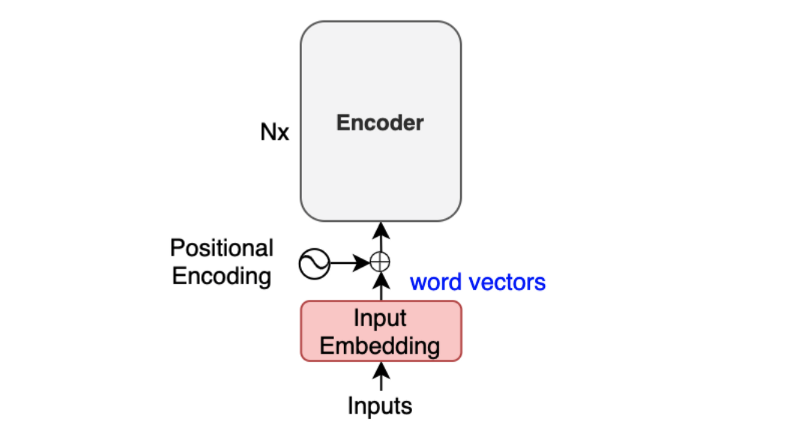

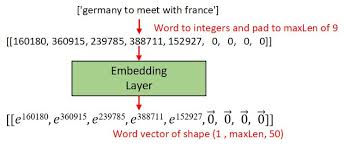

In [45]:
class Embeddings(nn.Module):
    """Construct the embeddings from word, position and token_type embeddings"""

    def __init__(self, d_model, vocab):
        super().__init__()
        self.embedding = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.d_model)
        return x

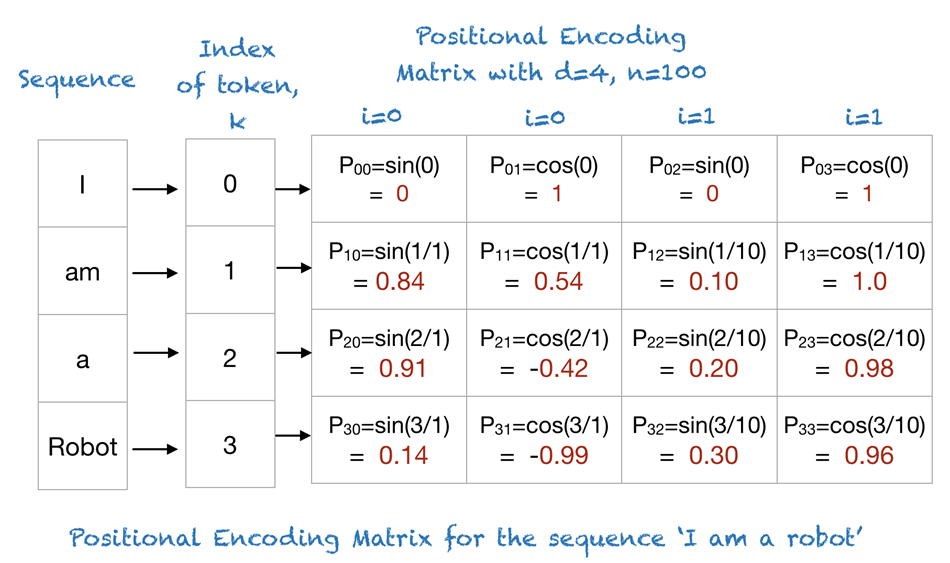

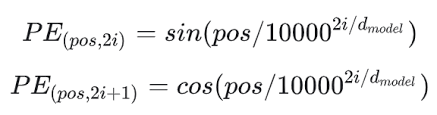

In [46]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout_rate, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # print(x)
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

##### __TransformerModel__

In [47]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h = 8, dropout_rate=0.1):
    """ Helper: Construct a model from hyperparameters."""
    c = copy.deepcopy
    # Multi-head attention mechanism layer
    attn_layer = MultiHeadAttention(h=h, d_model=d_model, dropout_rate=dropout_rate)
    # Feed forward layer with 2 linear layers
    feed_forward = PositionwiseFeedForward(
        d_model=d_model, d_ff=d_ff, dropout_rate=dropout_rate
    )
    # Embedding layer for source
    src_embedding_layer = Embeddings(d_model, src_vocab)
    # Embedding layer for target
    tgt_embedding_layer = Embeddings(d_model, tgt_vocab)
    # Positional encoding layer
    position_embedding_layer = PositionalEncoding(
        d_model=d_model, dropout_rate=dropout_rate
    )
    # Encoder layer with N encoder blocks
    encoder_layer = Encoder(
        EncoderBlock(
            size=d_model,
            self_attn=c(attn_layer),
            feed_forward=c(feed_forward),
            dropout_rate=dropout_rate,
        ),
        N,
    )

    # Decoder layer with N decoder blocks
    decoder_layer = Decoder(
        DecoderBlock(
            size=d_model,
            self_attn=c(attn_layer),
            src_attn=c(attn_layer),
            feed_forward=c(feed_forward),
            dropout_rate=dropout_rate,
        ),
        N,
    )

    # Projection layer for final output
    projection_layer = ProjectionLayer(d_model=d_model, vocab=tgt_vocab)

    # Transformer model with encoder, decoder, src_embedding, tgt_embedding, projection
    transformer_model = EncoderDecoder(
        encoder=encoder_layer,
        decoder=decoder_layer,
        src_embed=nn.Sequential(src_embedding_layer, c(position_embedding_layer)),
        tgt_embed=nn.Sequential(tgt_embedding_layer, c(position_embedding_layer)),
        generator=projection_layer,
    )

    for p in transformer_model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return transformer_model

##### __InferenceTest__

In [50]:
config = Config()

In [51]:
transformer_model = make_model(
    src_vocab=11,
    tgt_vocab=11,
    N=config.N,
    d_model=config.d_model,
    d_ff=config.d_ff,
    h=config.h,
    dropout_rate=config.dropout_rate,
)

print(transformer_model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderBlock(
        (self_attn): MultiHeadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=False)
          (w_k): Linear(in_features=512, out_features=512, bias=False)
          (w_v): Linear(in_features=512, out_features=512, bias=False)
          (w_o): Linear(in_features=512, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (ff1): Linear(in_features=512, out_features=2048, bias=False)
          (ff2): Linear(in_features=2048, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SubLayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleL

In [52]:
def inference_test():
    # Initialize the model
    transformer_model = make_model(
        src_vocab=11,
        tgt_vocab=11,
        N=config.N,
        d_model=config.d_model,
        d_ff=config.d_ff,
        h=config.h,
        dropout_rate=config.dropout_rate,
    )

    transformer_model.eval()
    # source batch
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    print(f"shape of the source {src.shape}")  # (batch * token)

    # for self attention we take all the tokens
    src_mask = torch.ones(1, 1, 10)

    print(f"shape of source mask {src_mask.shape}")

    # Encoder output comes from the encoder layer all at once
    encoder_output = transformer_model.encoder_step(src=src, src_mask=src_mask)
    print(encoder_output.shape)  # op will be 3 dim (batch*token*ndim)

    # placeholder for target predictions (start with <sos>)
    ys = torch.zeros(1, 1).type_as(src)
    print(f"shape of initial target {ys.shape}")

    for i in range(9):
        print(f"Sequential Prediction {i}")
        tgt_mask = attention_mask(ys.size(1)).type_as(src.data)
        # print(ys.shape, tgt_mask.shape)
        out = transformer_model.decoder_step(
            memory=encoder_output, src_mask=src_mask, tgt=ys, tgt_mask=tgt_mask
        )
        prob = transformer_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)
    print(f"shape of target after seq predictions: {ys.shape}")

In [53]:
inference_test()

shape of the source torch.Size([1, 10])
shape of source mask torch.Size([1, 1, 10])
torch.Size([1, 10, 512])
shape of initial target torch.Size([1, 1])
Sequential Prediction 0


/tmp/ipykernel_469851/1692549180.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  op = F.log_softmax(self.projection(x))


Sequential Prediction 1
Sequential Prediction 2
Sequential Prediction 3
Sequential Prediction 4
Sequential Prediction 5
Sequential Prediction 6
Sequential Prediction 7
Sequential Prediction 8
Example Untrained Model Prediction: tensor([[0, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
shape of target after seq predictions: torch.Size([1, 10])


References:
* https://kikaben.com/transformers-self-attention/